In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [94]:
# Load dataset
df = pd.read_csv("cleaned_data.csv")
print(df)

     PCOS (Y/N)  Age (yrs)   BMI  Pulse rate(bpm)  RR (breaths/min)  Hb(g/dl)  \
0             0         28  19.3               78                22     10.48   
1             0         36  24.9               74                20     11.70   
2             1         33  25.3               72                18     11.80   
3             0         37  29.7               72                20     12.00   
4             0         25  20.1               72                18     10.00   
..          ...        ...   ...              ...               ...       ...   
526           0         35  18.5               72                16     11.00   
527           0         30  25.3               72                18     10.80   
528           0         36  23.4               74                20     10.80   
529           0         27  22.2               74                20     12.00   
530           1         23  30.1               80                20     10.20   

     Menstrual Cycle Length

In [95]:
df.columns

Index(['PCOS (Y/N)', 'Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'RR (breaths/min)',
       'Hb(g/dl)', 'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)',
       'Pregnant(Y/N)', 'No. of abortions', 'I   beta-HCG(mIU/mL)',
       'II    beta-HCG(mIU/mL)', 'FSH/LH', 'Waist:Hip Ratio', 'TSH (mIU/L)',
       'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)',
       'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Blood Group_A+', 'Blood Group_A-', 'Blood Group_AB+',
       'Blood Group_AB-', 'Blood Group_B+', 'Blood Group_B-', 'Blood Group_O+',
       'Blood Group_O-', 'Menstrual Cycle(R/I)_irregular',
       'Menstrual Cycle(R/I)_regular'],
      dtype='object')

In [96]:
X = df.drop(columns='PCOS (Y/N)')
y = df['PCOS (Y/N)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
# Separate numerical and categorical columns
cat_cols = ['Pregnant(Y/N)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)',
            'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Blood Group_A+', 'Blood Group_A-',
            'Blood Group_AB+', 'Blood Group_AB-', 'Blood Group_B+', 'Blood Group_B-', 'Blood Group_O+',
            'Blood Group_O-', 'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular']
cat_df_train = X_train[cat_cols]
cat_df_test = X_test[cat_cols]

cat_df_train = cat_df_train.reset_index(drop=True)
cat_df_test = cat_df_test.reset_index(drop=True)

num_cols = X_train.drop(columns=cat_cols+['PCOS (Y/N)'], errors='ignore').columns

# Scale numerical features only
scaler = StandardScaler()
df_scaled_train = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
df_scaled_test = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

# Combine scaled numerical and encoded categorical features
X_train = pd.concat([df_scaled_train, cat_df_train], axis=1)
X_test = pd.concat([df_scaled_test, cat_df_test], axis=1)

In [98]:
# Train the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)


Accuracy: 0.8504672897196262
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        72
           1       0.77      0.77      0.77        35

    accuracy                           0.85       107
   macro avg       0.83      0.83      0.83       107
weighted avg       0.85      0.85      0.85       107

AUC-ROC Score: 0.9206349206349206


# Predicting with PCA

In [99]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

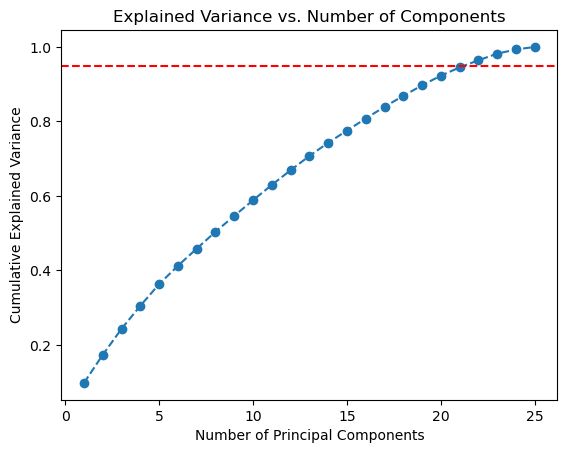

Selected 22 components to retain 95% variance.


In [100]:
# Apply PCA
pca = PCA()
X_pca_train = pca.fit_transform(df_scaled_train)
X_pca_test = pca.transform(df_scaled_test)

# Plot explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold
plt.show()

# Select the number of components needed for 95% variance
num_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Selected {num_components} components to retain 95% variance.")

X_reduced_train = X_pca_train[:, :num_components]  # Keep only selected components
X_reduced_test = X_pca_test[:, :num_components]

In [101]:
# Convert NumPy array back to DataFrame
X_pca_num_train = pd.DataFrame(X_reduced_train, columns=[f'PC{i+1}' for i in range(X_reduced_train.shape[1])])
X_pca_num_test = pd.DataFrame(X_reduced_test, columns=[f'PC{i+1}' for i in range(X_reduced_test.shape[1])])

# Combine results with the one-hot encoded columns
X_pca_df_train = pd.concat([X_pca_num_train, cat_df_train], axis=1)
X_pca_df_test = pd.concat([X_pca_num_test, cat_df_test], axis=1)

In [102]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_pca_df_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_pca_df_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_pca_df_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# F1-score decreased
# AUC-ROC decreased

Accuracy: 0.822429906542056
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87        72
           1       0.75      0.69      0.72        35

    accuracy                           0.82       107
   macro avg       0.80      0.79      0.79       107
weighted avg       0.82      0.82      0.82       107

AUC-ROC Score: 0.9027777777777777


# SVM with RFE

In [103]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Initialize model (RandomForest for ranking)
model = RandomForestClassifier(n_estimators=100, random_state=4262)

# Try different numbers of features
n_features_list = [5, 10, 15, 20, 25]  # Number of features to select
scores = []

for n_features in n_features_list:
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    X_rfe = rfe.fit_transform(X_train, y_train)
    
    # Evaluate performance with cross-validation
    score = cross_val_score(model, X_rfe, y_train, cv=5)  # 5-fold cross-validation
    scores.append(score.mean())  # Store the mean score

# Identify the optimal number of features
optimal_n_features = n_features_list[scores.index(max(scores))]
print("Optimal number of features:", optimal_n_features)

Optimal number of features: 20


In [105]:
# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=20)  # Keep top 20 features
X_rfe = rfe.fit_transform(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", list(selected_features))

Selected Features: ['Age (yrs)', 'BMI', 'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)', 'FSH/LH', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Fast food (Y/N)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)', 'Menstrual Cycle(R/I)_irregular']


In [106]:
# Convert the result (X_rfe) back to a DataFrame
X_rfe_train = pd.DataFrame(X_rfe, columns=selected_features)
X_rfe_test = pd.DataFrame(X_test, columns=selected_features)

In [107]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42) 
svm_model.fit(X_rfe_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# improved

Accuracy: 0.8504672897196262
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        72
           1       0.77      0.77      0.77        35

    accuracy                           0.85       107
   macro avg       0.83      0.83      0.83       107
weighted avg       0.85      0.85      0.85       107

AUC-ROC Score: 0.9428571428571428


# Upsampling with SMOTE

In [108]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({0: 288, 1: 136})
After SMOTE: Counter({1: 288, 0: 288})


In [109]:
X_resampled = pd.DataFrame(X_resampled, columns=X_resampled.columns)

In [110]:
# Initialize model (RandomForest for ranking)
model = RandomForestClassifier(n_estimators=100, random_state=123)

# Try different numbers of features
n_features_list = [5, 10, 15, 20, 25]  # Number of features to select
scores = []

for n_features in n_features_list:
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)
    
    # Evaluate performance with cross-validation
    score = cross_val_score(model, X_rfe, y_resampled, cv=5)  # 5-fold cross-validation
    scores.append(score.mean())  # Store the mean score

# Identify the optimal number of features
optimal_n_features = n_features_list[scores.index(max(scores))]
print("Optimal number of features:", optimal_n_features)

Optimal number of features: 25


In [111]:
# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=20)  # Keep top 20 features
X_rfe = rfe.fit_transform(X_resampled, y_resampled)

# Get selected feature names
selected_features = X_resampled.columns[rfe.support_]
print("Selected Features:", list(selected_features))

Selected Features: ['Age (yrs)', 'BMI', 'Hb(g/dl)', 'Menstrual Cycle Length(days)', 'FSH/LH', 'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'Skin darkening (Y/N)', 'Fast food (Y/N)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)', 'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular']


In [112]:
# Convert the result (X_rfe) back to a DataFrame
X_resampled_rfe_df = pd.DataFrame(X_rfe, columns=selected_features)

X_smote_rfe_test = pd.DataFrame(X_test, columns=selected_features)

In [113]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_resampled_rfe_df, y_resampled)

# Make predictions
y_pred = svm_model.predict(X_smote_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_smote_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# other metrics increased
# AUC-ROC decreased

Accuracy: 0.8037383177570093
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85        72
           1       0.68      0.74      0.71        35

    accuracy                           0.80       107
   macro avg       0.78      0.79      0.78       107
weighted avg       0.81      0.80      0.81       107

AUC-ROC Score: 0.9067460317460316


## Using SMOTE + Tomek

In [114]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_resampled_t, y_resampled_t = smote_tomek.fit_resample(X_resampled, y_resampled)

In [115]:
X_resampled_t = pd.DataFrame(X_resampled_t, columns=X_resampled_t.columns)

In [116]:
# Initialize model (RandomForest for ranking)
model = RandomForestClassifier(n_estimators=100, random_state=123)

# Try different numbers of features
n_features_list = [5, 10, 15, 20, 25]  # Number of features to select
scores = []

for n_features in n_features_list:
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    X_rfe = rfe.fit_transform(X_resampled_t, y_resampled_t)
    
    # Evaluate performance with cross-validation
    score = cross_val_score(model, X_rfe, y_resampled_t, cv=5)  # 5-fold cross-validation
    scores.append(score.mean())  # Store the mean score

# Identify the optimal number of features
optimal_n_features = n_features_list[scores.index(max(scores))]
print("Optimal number of features:", optimal_n_features)

Optimal number of features: 25


In [117]:
# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=25)  # Keep top 25 features
X_rfe = rfe.fit_transform(X_resampled_t, y_resampled_t)

# Get selected feature names
selected_features = X_resampled_t.columns[rfe.support_]
print("Selected Features:", list(selected_features))

Selected Features: ['Age (yrs)', 'BMI', 'Hb(g/dl)', 'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)', 'I   beta-HCG(mIU/mL)', 'FSH/LH', 'Waist:Hip Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Fast food (Y/N)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)', 'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular']


In [118]:
# Convert the result (X_rfe) back to a DataFrame
X_resampled_t_rfe_df = pd.DataFrame(X_rfe, columns=selected_features)

X_t_rfe_test = pd.DataFrame(X_test, columns=selected_features)

In [119]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_resampled_t_rfe_df, y_resampled_t)

# Make predictions
y_pred = svm_model.predict(X_t_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_t_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# improved?

Accuracy: 0.8411214953271028
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88        72
           1       0.76      0.74      0.75        35

    accuracy                           0.84       107
   macro avg       0.82      0.82      0.82       107
weighted avg       0.84      0.84      0.84       107

AUC-ROC Score: 0.9027777777777777


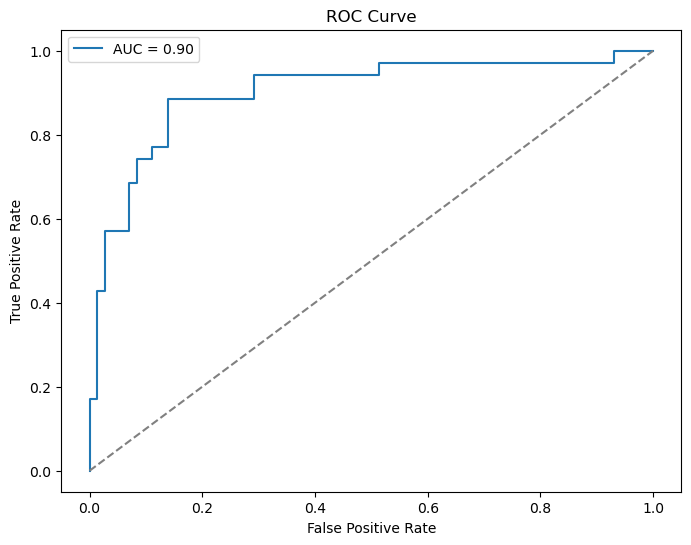

In [120]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Assign class weights

In [121]:
# using class weights from svm

# Train the SVM model
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42) 
svm_model.fit(X_rfe_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# other metrics decreased, AUC-ROC increased
# SMOTE better?

Accuracy: 0.8785046728971962
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91        72
           1       0.79      0.86      0.82        35

    accuracy                           0.88       107
   macro avg       0.86      0.87      0.86       107
weighted avg       0.88      0.88      0.88       107

AUC-ROC Score: 0.9432539682539682


# Choose best params for SVM

In [122]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear', 'rbf', 'poly'],  
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_resampled_t_rfe_df, y_resampled_t)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [123]:
best_params = grid_search.best_params_

svm_model = SVC(
    C=best_params['C'], 
    kernel=best_params['kernel'], 
    gamma=best_params.get('gamma', 'scale')  
)

svm_model.fit(X_resampled_t_rfe_df, y_resampled_t)

# Make predictions
y_pred = svm_model.predict(X_t_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_t_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

Accuracy: 0.8411214953271028
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88        72
           1       0.76      0.74      0.75        35

    accuracy                           0.84       107
   macro avg       0.82      0.82      0.82       107
weighted avg       0.84      0.84      0.84       107

AUC-ROC Score: 0.9027777777777777


# Feature Engineered Dataset

In [124]:
# Load feature engineered dataset
df = pd.read_csv("final_data.csv")
print(df)

     PCOS (Y/N)  Age (yrs)   BMI  Pulse rate(bpm)  \
0             0         28  19.3               78   
1             0         36  24.9               74   
2             1         33  25.3               72   
3             0         37  29.7               72   
4             0         25  20.1               72   
..          ...        ...   ...              ...   
524           0         35  18.5               72   
525           0         30  25.3               72   
526           0         36  23.4               74   
527           0         27  22.2               74   
528           1         23  30.1               80   

     Menstrual Cycle Length(days)  Marriage Status (Yrs)  Pregnant(Y/N)  \
0                               5                    7.0              0   
1                               5                   11.0              1   
2                               5                   10.0              1   
3                               5                    4.0       

In [125]:
X = df.drop(columns='PCOS (Y/N)')
y = df['PCOS (Y/N)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
X_train.columns

Index(['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'Menstrual Cycle Length(days)',
       'Marriage Status (Yrs)', 'Pregnant(Y/N)', 'No. of abortions',
       'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH/LH',
       'Waist:Hip Ratio', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)', 'Blood Group_A+', 'Blood Group_A-',
       'Blood Group_AB+', 'Blood Group_AB-', 'Blood Group_B+',
       'Blood Group_B-', 'Blood Group_O+', 'Blood Group_O-',
       'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular',
       'Symptoms score', 'Unhealthy living score', 'RR (breaths/min)_high',
       'RR (breaths/min)_normal', 'Hb(g/dl)_low', 'Hb(g/dl)_normal',
       'TSH (mIU/L)_high', 'TSH (mIU/L)_low', 'TSH (mIU/L)_normal',
       'AMH(ng/mL)_high', 'AMH(ng/mL)_lo

In [127]:
# Separate numerical and categorical columns
num_cols = ['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)',
            'No. of abortions', 'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH/LH',
            'Waist:Hip Ratio', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)',
            'Avg. F size (R) (mm)', 'Endometrium (mm)']

cat_cols = X_train.drop(columns=num_cols+['PCOS (Y/N)'], errors='ignore').columns

cat_df_train = X_train[cat_cols]
cat_df_test = X_test[cat_cols]

cat_df_train = cat_df_train.reset_index(drop=True)
cat_df_test = cat_df_test.reset_index(drop=True)

# Scale numerical features only
scaler = StandardScaler()
df_scaled_train = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
df_scaled_test = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

# Combine scaled numerical and encoded categorical features
X_train = pd.concat([df_scaled_train, cat_df_train], axis=1)
X_test = pd.concat([df_scaled_test, cat_df_test], axis=1)

In [128]:
# Train the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

Accuracy: 0.8867924528301887
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92        74
           1       0.79      0.84      0.82        32

    accuracy                           0.89       106
   macro avg       0.86      0.87      0.87       106
weighted avg       0.89      0.89      0.89       106

AUC-ROC Score: 0.9497466216216217


# Predicting with PCA

In [129]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

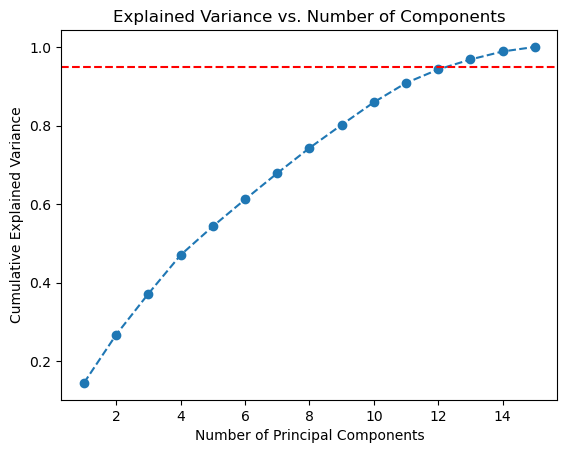

Selected 13 components to retain 95% variance.


In [130]:
# Apply PCA
pca = PCA()
X_pca_train = pca.fit_transform(df_scaled_train)
X_pca_test = pca.transform(df_scaled_test)

# Plot explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold
plt.show()

# Select the number of components needed for 95% variance
num_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Selected {num_components} components to retain 95% variance.")

X_reduced_train = X_pca_train[:, :num_components]  # Keep only selected components
X_reduced_test = X_pca_test[:, :num_components]

In [131]:
# Convert NumPy array back to DataFrame
X_pca_num_train = pd.DataFrame(X_reduced_train, columns=[f'PC{i+1}' for i in range(X_reduced_train.shape[1])])
X_pca_num_test = pd.DataFrame(X_reduced_test, columns=[f'PC{i+1}' for i in range(X_reduced_test.shape[1])])

# Combine results with the one-hot encoded columns
X_pca_df_train = pd.concat([X_pca_num_train, cat_df_train], axis=1)
X_pca_df_test = pd.concat([X_pca_num_test, cat_df_test], axis=1)

In [132]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_pca_df_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_pca_df_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_pca_df_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# AUC-ROC increased, F1 decreased slightly

Accuracy: 0.8867924528301887
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        74
           1       0.83      0.78      0.81        32

    accuracy                           0.89       106
   macro avg       0.87      0.86      0.86       106
weighted avg       0.89      0.89      0.89       106

AUC-ROC Score: 0.9645270270270271


# SVM with RFE

In [133]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Initialize model (RandomForest for ranking)
model = RandomForestClassifier(n_estimators=100, random_state=4262)

# Try different numbers of features
n_features_list = [5, 10, 15, 20, 25]  # Number of features to select
scores = []

for n_features in n_features_list:
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    X_rfe = rfe.fit_transform(X_train, y_train)
    
    # Evaluate performance with cross-validation
    score = cross_val_score(model, X_rfe, y_train, cv=5)  # 5-fold cross-validation
    scores.append(score.mean())  # Store the mean score

# Identify the optimal number of features
optimal_n_features = n_features_list[scores.index(max(scores))]
print("Optimal number of features:", optimal_n_features)

Optimal number of features: 20


In [134]:
# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=20)  # Keep top 20 features
X_rfe = rfe.fit_transform(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", list(selected_features))

Selected Features: ['Age (yrs)', 'BMI', 'Pulse rate(bpm)', 'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)', 'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH/LH', 'Waist:Hip Ratio', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular', 'Symptoms score']


In [135]:
# Convert the result (X_rfe) back to a DataFrame
X_rfe_train = pd.DataFrame(X_rfe, columns=selected_features)
X_rfe_test = pd.DataFrame(X_test, columns=selected_features)

In [136]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42) 
svm_model.fit(X_rfe_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# slightly higher f1 and AUC-ROC

Accuracy: 0.8867924528301887
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92        74
           1       0.79      0.84      0.82        32

    accuracy                           0.89       106
   macro avg       0.86      0.87      0.87       106
weighted avg       0.89      0.89      0.89       106

AUC-ROC Score: 0.9679054054054054


# Upsampling with SMOTE

In [137]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the class distribution before SMOTE
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({0: 284, 1: 139})
After SMOTE: Counter({0: 284, 1: 284})


In [138]:
X_resampled = pd.DataFrame(X_resampled, columns=X_resampled.columns)

In [139]:
# Initialize model (RandomForest for ranking)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Try different numbers of features
n_features_list = [5, 10, 15, 20, 25]  # Number of features to select
scores = []

for n_features in n_features_list:
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    X_rfe = rfe.fit_transform(X_resampled, y_resampled)
    
    # Evaluate performance with cross-validation
    score = cross_val_score(model, X_rfe, y_resampled, cv=5)  # 5-fold cross-validation
    scores.append(score.mean())  # Store the mean score

# Identify the optimal number of features
optimal_n_features = n_features_list[scores.index(max(scores))]
print("Optimal number of features:", optimal_n_features)

Optimal number of features: 20


In [140]:
# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=20)  # Keep top 20 features
X_rfe = rfe.fit_transform(X_resampled, y_resampled)

# Get selected feature names
selected_features = X_resampled.columns[rfe.support_]
print("Selected Features:", list(selected_features))

Selected Features: ['Age (yrs)', 'BMI', 'Menstrual Cycle Length(days)', 'Marriage Status (Yrs)', 'I   beta-HCG(mIU/mL)', 'FSH/LH', 'Waist:Hip Ratio', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Fast food (Y/N)', 'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular', 'Symptoms score', 'Unhealthy living score']


In [141]:
# Convert the result (X_rfe) back to a DataFrame
X_resampled_rfe_df = pd.DataFrame(X_rfe, columns=selected_features)

X_smote_rfe_test = pd.DataFrame(X_test, columns=selected_features)

In [142]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_resampled_rfe_df, y_resampled)

# Make predictions
y_pred = svm_model.predict(X_smote_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_smote_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# About the same

Accuracy: 0.8773584905660378
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91        74
           1       0.74      0.91      0.82        32

    accuracy                           0.88       106
   macro avg       0.85      0.89      0.86       106
weighted avg       0.89      0.88      0.88       106

AUC-ROC Score: 0.9653716216216217


# SMOTE + Tomek

In [143]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_resampled_t, y_resampled_t = smote_tomek.fit_resample(X_resampled, y_resampled)

In [144]:
X_resampled_t = pd.DataFrame(X_resampled_t, columns=X_resampled_t.columns)

In [145]:
# Initialize model (RandomForest for ranking)
model = RandomForestClassifier(n_estimators=100, random_state=123)

# Try different numbers of features
n_features_list = [5, 10, 15, 20, 25]  # Number of features to select
scores = []

for n_features in n_features_list:
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    X_rfe = rfe.fit_transform(X_resampled_t, y_resampled_t)
    
    # Evaluate performance with cross-validation
    score = cross_val_score(model, X_rfe, y_resampled_t, cv=5)  # 5-fold cross-validation
    scores.append(score.mean())  # Store the mean score

# Identify the optimal number of features
optimal_n_features = n_features_list[scores.index(max(scores))]
print("Optimal number of features:", optimal_n_features)

Optimal number of features: 10


In [146]:
# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=10)  # Keep top 10 features
X_rfe = rfe.fit_transform(X_resampled_t, y_resampled_t)

# Get selected feature names
selected_features = X_resampled_t.columns[rfe.support_]
print("Selected Features:", list(selected_features))

Selected Features: ['Age (yrs)', 'BMI', 'Menstrual Cycle Length(days)', 'FSH/LH', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Menstrual Cycle(R/I)_irregular', 'Menstrual Cycle(R/I)_regular', 'Symptoms score']


In [147]:
# Convert the result (X_rfe) back to a DataFrame
X_resampled_t_rfe_df = pd.DataFrame(X_rfe, columns=selected_features)

X_t_rfe_test = pd.DataFrame(X_test, columns=selected_features)

In [148]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_resampled_t_rfe_df, y_resampled_t)

# Make predictions
y_pred = svm_model.predict(X_t_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_t_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# f1 increased slightly

Accuracy: 0.8773584905660378
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91        74
           1       0.76      0.88      0.81        32

    accuracy                           0.88       106
   macro avg       0.85      0.88      0.86       106
weighted avg       0.89      0.88      0.88       106

AUC-ROC Score: 0.9619932432432433


# Assign Class Weights

In [149]:
# using class weights from svm

# Train the SVM model
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42) 
svm_model.fit(X_rfe_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

# decreased

Accuracy: 0.8679245283018868
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90        74
           1       0.72      0.91      0.81        32

    accuracy                           0.87       106
   macro avg       0.84      0.88      0.85       106
weighted avg       0.89      0.87      0.87       106

AUC-ROC Score: 0.957347972972973


# Choose Best Params for SVM

In [160]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear', 'rbf', 'poly'],  
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_resampled_t_rfe_df, y_resampled_t)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
best_params = grid_search.best_params_

svm_model = SVC(
    C=best_params['C'], 
    kernel=best_params['kernel'], 
    gamma=best_params.get('gamma', 'scale'),
    random_state=123 
)

svm_model.fit(X_resampled_t_rfe_df, y_resampled_t)

# Make predictions
y_pred = svm_model.predict(X_t_rfe_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get decision scores
y_scores = svm_model.decision_function(X_t_rfe_test)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_roc)

Accuracy: 0.8679245283018868
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90        74
           1       0.75      0.84      0.79        32

    accuracy                           0.87       106
   macro avg       0.84      0.86      0.85       106
weighted avg       0.87      0.87      0.87       106

AUC-ROC Score: 0.9611486486486487
